In [87]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform, cdist
from scipy import stats as st
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from tqdm import tqdm

#### Reading data 

In [88]:
df = pd.read_csv('./ChurnData.csv')
print(df.shape)
df.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,NaN,42,2,0.00,1,1,1,10134888.0,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,11254258.0,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,11393157.0,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,0.0,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,7908410.0,0


#### Data Analysis 

In [89]:
#drop rownumber, custId and Surname as they don't have a role in predicting exited
df=df.drop(columns={'RowNumber', 'CustomerId', 'Surname'})
print(df.shape)
df.head()

(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,NaN,42,2,0.00,1,1,1,10134888.0,1
1,608,Spain,Female,41,1,83807.86,1,0,1,11254258.0,0
2,502,France,Female,42,8,159660.80,3,1,0,11393157.0,1
3,699,France,Female,39,1,0.00,2,0,0,0.0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,7908410.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           8571 non-null   object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  8576 non-null   float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


#### Invalid entries 

In [10]:
#Lets find out if there are invalid entries in data
nul_cols = df.isnull().any(0)
for col in nul_cols.index:
    if nul_cols[col]==True:
        print(col, 'has', df[df[col].isnull()].shape[0], 'invalid entries')

Gender has 1429 invalid entries
EstimatedSalary has 1424 invalid entries


In [90]:
df['Gender'].fillna(value='missing', inplace = True)

In [91]:
df['EstSalary_median'] = df['EstimatedSalary'].fillna(value=df['EstimatedSalary'].median())

In [5]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,8.576000e+03,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,1.376025e+05,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,1.227497e+06,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000e+00,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,5.127141e+04,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,1.005619e+05,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,1.494056e+05,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,1.009485e+08,1.000000


In [6]:
for col in df.columns:
    if col in ['EstimatedSalary', 'Balance', 'CreditScore']:continue
    print('unique values in', col, set(df[col]))

unique values in Geography {'Spain', 'France', 'Germany'}
unique values in Gender {nan, 'Male', 'Female'}
unique values in Age {18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 88, 92}
unique values in Tenure {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
unique values in NumOfProducts {1, 2, 3, 4}
unique values in HasCrCard {0, 1}
unique values in IsActiveMember {0, 1}
unique values in Exited {0, 1}


#### Target distribution 

In [7]:
t = df.groupby('Exited')['Exited'].count()
print('% Exited', np.round((t[1]/(t[1]+t[0]))*100, 2),"%")
print('% Not Exited', np.round((t[0]/(t[1]+t[0]))*100, 2),"%")
#It suggests that it's a skewed dataset, hence a metric like accuracy shoudnt be used for evaluation

% Exited 20.37 %
% Not Exited 79.63 %


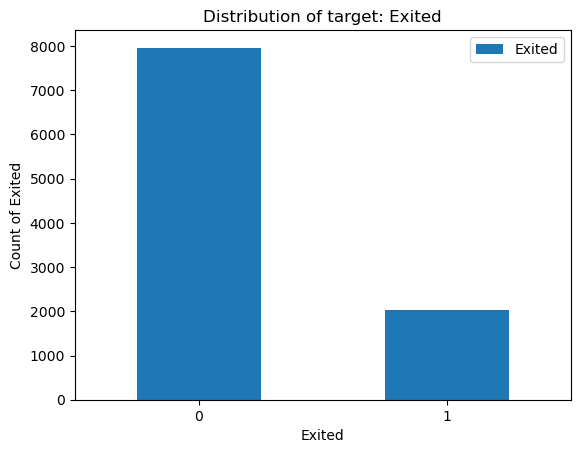

In [8]:
plt.title('Distribution of target: Exited')
df.groupby('Exited')['Exited'].count().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Exited')
plt.ylabel('Count of Exited')
plt.legend()

In [104]:
#Imbalanced dataset. Helps in deiciding the performance metric, like accuracy may not be 
#appropriate here. 

#### Exploratory Data Analysis 

Text(0.5, 1.0, 'Distribution of log_est_salary with Exited')

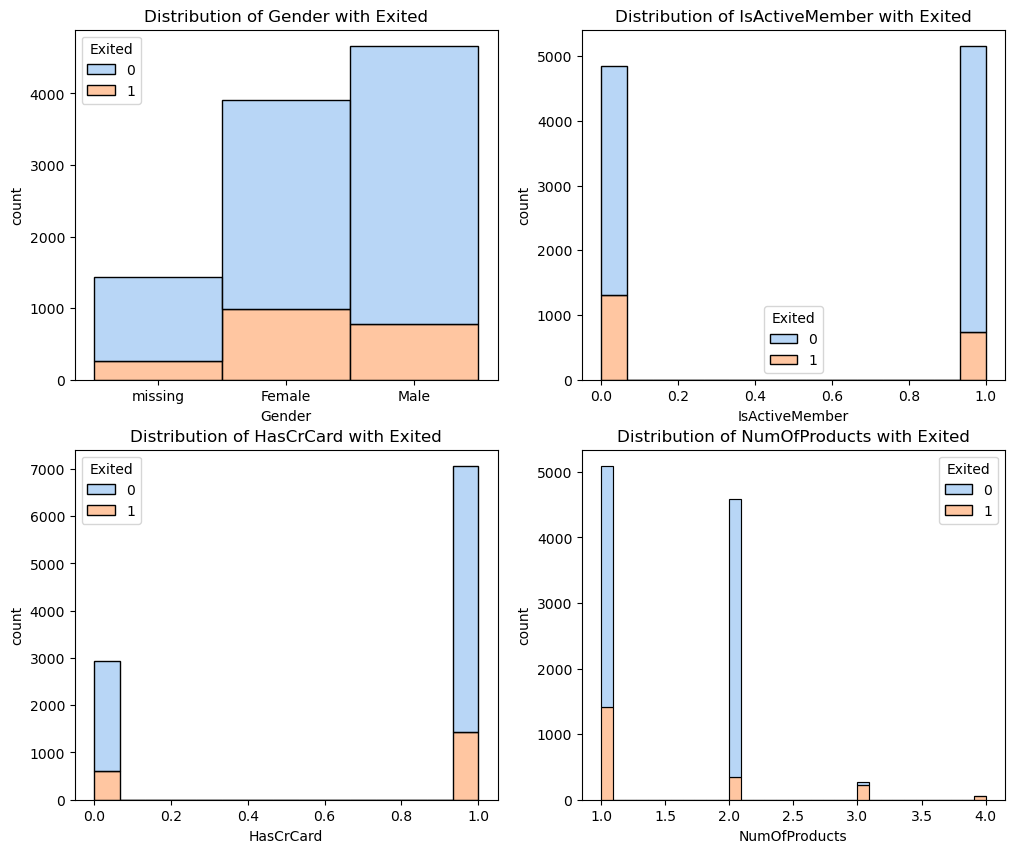

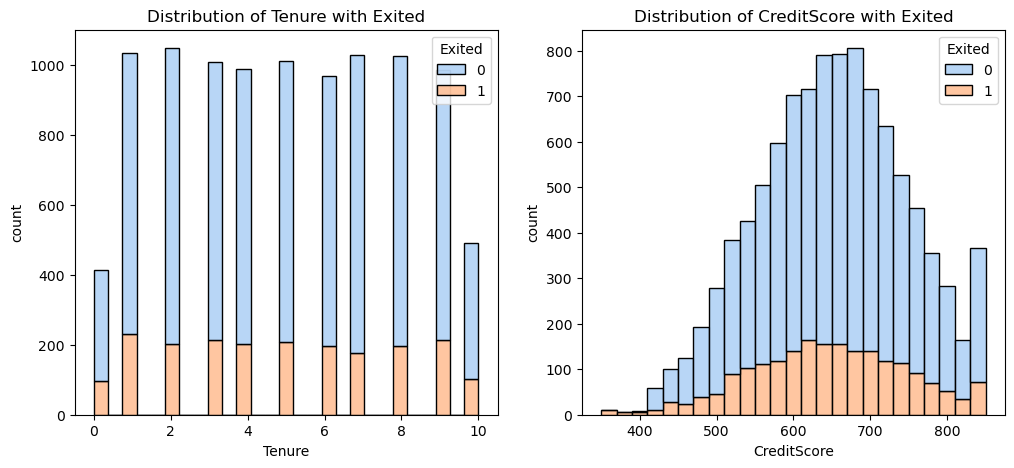

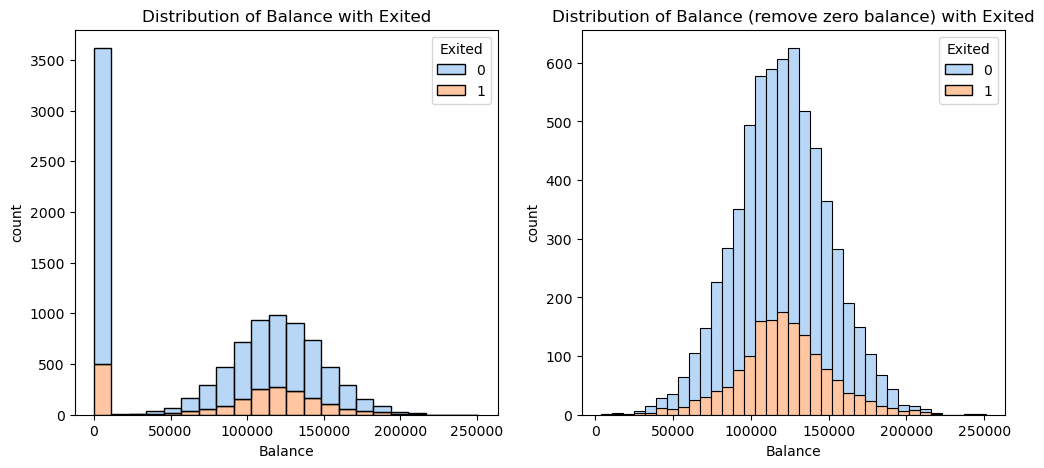

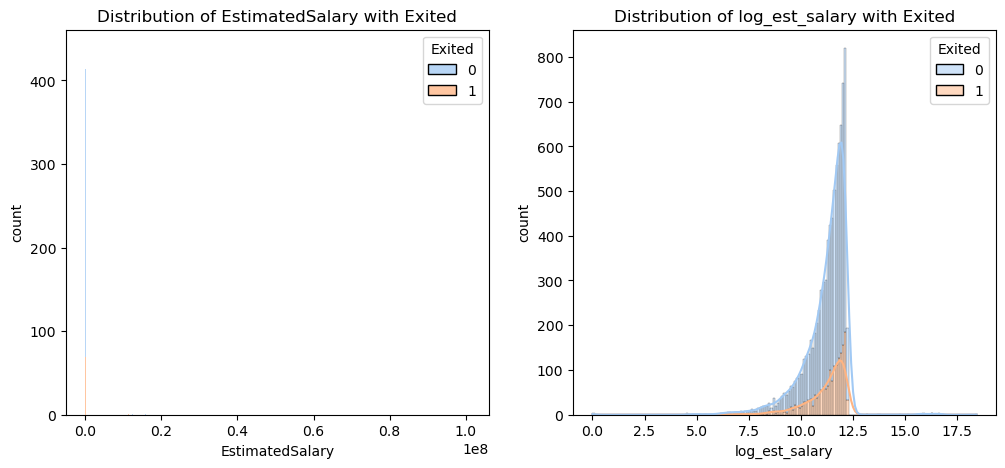

In [94]:
f = plt.figure(figsize=(12,10))
ax = f.add_subplot(2,2,1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="Gender", kde=False,
             palette="pastel", hue="Exited",
             element="bars", legend=True)
ax.set_xlabel('Gender')
ax.set_ylabel('count')
ax.set_title('Distribution of Gender with Exited')

ax = f.add_subplot(2,2,2)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="IsActiveMember", kde=False,
             palette="pastel", hue="Exited",
             element="bars", legend=True, )
ax.set_xlabel('IsActiveMember')
ax.set_ylabel('count')
ax.set_title('Distribution of IsActiveMember with Exited')

ax = f.add_subplot(2,2,3)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="HasCrCard", kde=False,
             palette="pastel", hue="Exited",
             element="bars", legend=True)
ax.set_xlabel('HasCrCard')
ax.set_ylabel('count')
ax.set_title('Distribution of HasCrCard with Exited')

ax = f.add_subplot(2,2,4)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="NumOfProducts", kde=False,
             palette="pastel", hue="Exited",
             element="bars", legend=True)
ax.set_xlabel('NumOfProducts')
ax.set_ylabel('count')
ax.set_title('Distribution of NumOfProducts with Exited')

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,2,1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="Tenure", kde=False,
             palette="pastel", hue="Exited",
             element="bars", legend=True)
ax.set_xlabel('Tenure')
ax.set_ylabel('count')
ax.set_title('Distribution of Tenure with Exited')

ax = f.add_subplot(1,2,2)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="CreditScore", kde=False,
             palette="pastel", hue="Exited",
             element="bars", legend=True, bins = 25)
ax.set_xlabel('CreditScore')
ax.set_ylabel('count')
ax.set_title('Distribution of CreditScore with Exited')

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,2,1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="Balance", kde=False,
             palette="pastel", hue="Exited",
             element="bars", legend=True)
ax.set_xlabel('Balance')
ax.set_ylabel('count')
ax.set_title('Distribution of Balance with Exited')

ax = f.add_subplot(1,2,2)
sns.histplot(data=df[df['Balance']>0], ax=ax, stat="count", multiple="stack",
             x="Balance", kde=False,
             palette="pastel", hue="Exited",
             element="bars", legend=True, bins = 35)
ax.set_xlabel('Balance')
ax.set_ylabel('count')
ax.set_title('Distribution of Balance (remove zero balance) with Exited')


f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,2,1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="EstimatedSalary", kde=False,
             palette="pastel", hue="Exited",
             element="bars", legend=True)
ax.set_xlabel('EstimatedSalary')
ax.set_ylabel('count')
ax.set_title('Distribution of EstimatedSalary with Exited')

df['log_est_salary'] = df['EstimatedSalary'].apply(lambda x:np.log(1+x))
ax = f.add_subplot(1,2,2)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="log_est_salary", kde=True,
             palette="pastel", hue="Exited",
             element="bars", legend=True)
ax.set_xlabel('log_est_salary')
ax.set_ylabel('count')
ax.set_title('Distribution of log_est_salary with Exited')

#### boxplot for checking outliers 

Text(0.5, 1.0, 'Boxplot of EstimatedSalary')

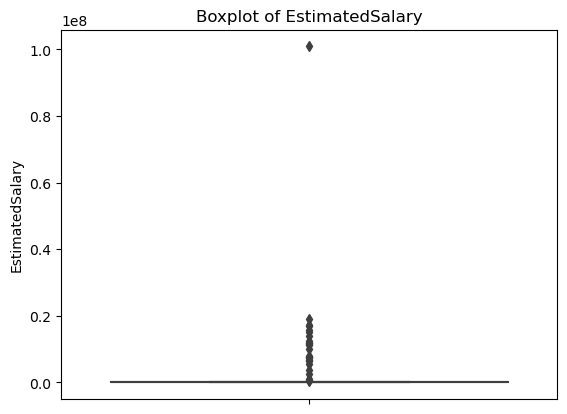

In [176]:
sns.boxplot(y='EstimatedSalary', data = df)
plt.title('Boxplot of EstimatedSalary')

In [26]:
bins = np.histogram_bin_edges(df['CreditScore'], bins='auto')

In [41]:
bins = np.histogram_bin_edges(df['CreditScore'], bins='auto')
bins[-1] = bins[-1]+0.1
dict_cc = {item:0 for item in bins}
for item in df['CreditScore']:
    for bin_ in bins:
        if item <bin_:
            dict_cc[bin_]+=1
            break

In [36]:
df[df['CreditScore']==850].shape[0]

233

In [40]:
df['CreditScore'].mean()
df['CreditScore'].std()

96.65329873613061

In [174]:
def bucketize(num, bucket):
    for key,value in bucket.items():
        min_, max_ = int(key.split('-')[0]), int(key.split('-')[1])
        if num>=min_ and num<=max_:
            return key
        else:continue
    print('no match for num', num)

bins = range(min(df['CreditScore']), max(df['CreditScore'])+1, 50)
bucket = {'300-350':0, '351-400':0, '401-450':0,'451-500':0, '501-550':0, '551-600':0, '601-650':0, '651-700':0, '701-750':0, '751-800':0, '801-850':0}
for cscore in df['CreditScore']:
    bucket[bucketize(cscore,bucket)]+=1
print(bucket)    

{'300-350': 5, '351-400': 14, '401-450': 170, '451-500': 454, '501-550': 978, '551-600': 1445, '601-650': 1871, '651-700': 1947, '701-750': 1518, '751-800': 953, '801-850': 645}


In [92]:
count = 0
for i in df['EstimatedSalary']:
    if i<1:
        count+=1
print(count)

4


### Modeling 

In [14]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,log_est_salary
0,619,France,missing,42,2,0.00,1,1,1,10134888.0,1,16.131494
1,608,Spain,Female,41,1,83807.86,1,0,1,11254258.0,0,16.236257
2,502,France,Female,42,8,159660.80,3,1,0,11393157.0,1,16.248524
3,699,France,Female,39,1,0.00,2,0,0,0.0,0,0.000000
4,850,Spain,Female,43,2,125510.82,1,1,1,7908410.0,0,15.883437


#### Categorical to numeric (one hot encoding) 

In [95]:
#converting categorical data gender and country to one hot encoding
ohe_gender = pd.get_dummies(df['Gender'])
ohe_geog = pd.get_dummies(df['Geography'])
df2 =pd.concat([df,ohe_gender, ohe_geog], axis='columns')
df2=df2.drop(columns=['Geography', 'Gender', 'missing', 'Spain','log_est_salary', 'EstimatedSalary'])
df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,EstSalary_median,Female,Male,France,Germany
0,619,42,2,0.00,1,1,1,1,10134888.0,0,0,1,0
1,608,41,1,83807.86,1,0,1,0,11254258.0,1,0,0,0
2,502,42,8,159660.80,3,1,0,1,11393157.0,1,0,1,0
3,699,39,1,0.00,2,0,0,0,0.0,1,0,1,0
4,850,43,2,125510.82,1,1,1,0,7908410.0,1,0,0,0


In [96]:
#Scaling of features is needed since KNN is based on some distance metric to compute similarity
y=df2['Exited'].values
df3=df2.drop(columns='Exited')
x=df3.values
print(x.shape, y.shape)
df3.head()

(10000, 12) (10000,)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstSalary_median,Female,Male,France,Germany
0,619,42,2,0.00,1,1,1,10134888.0,0,0,1,0
1,608,41,1,83807.86,1,0,1,11254258.0,1,0,0,0
2,502,42,8,159660.80,3,1,0,11393157.0,1,0,1,0
3,699,39,1,0.00,2,0,0,0.0,1,0,1,0
4,850,43,2,125510.82,1,1,1,7908410.0,1,0,0,0


#### Scaling 

In [17]:
class data_scaling(object):
    def __init__(self, ):
        self.x1=''
        self.x2=''
        
    def fit_transform(self, x_data, standardize=False, scaling=True):
        '''
        Fit & Transformation: mean centering and variance scaling
                              min-max scaling
        '''
        if standardize:
            xmean = np.mean(x_data, axis = 0)
            xstd = np.std(x_data, axis = 0)
            x_stdzd = np.divide(x_data- xmean, xstd, out=np.zeros_like(x_data, dtype='float'), where=xstd != 0)
            self.x1 = xmean
            self.x2 = xstd
            return x_stdzd
        if scaling:
            xmin = np.min(x_data, axis = 0)
            xmax = np.max(x_data, axis = 0)
            x_scaled = np.divide(x_data-xmin, xmax-xmin, out=np.zeros_like(x_data, dtype='float'), where=xmax-xmin != 0)
            self.x1 = xmin
            self.x2 = xmax-xmin
            return x_scaled
    
    def transform(self,x):
        '''
        Use training derived values to transform validation or test data
        '''
        x_trf = np.divide(x-self.x1, self.x2, out=np.zeros_like(x, dtype='float'), where=self.x2 != 0)
        return x_trf
    

#### KNN Classifier 

In [18]:
class KNN(object):
    def __init__(self, k=1, distance_metric='cityblock'):
        self.num_neighbours = k
        self.precision = 0
        self.recall = 0
        self.F1_score = 0
        self.accuracy = 0
        self.cfm = ''
        self.xtrain = ''
        self.ytrain = ''
        self.classes = ''
        if distance_metric.lower() not in ['cityblock', 'hamming', 'euclidean']:
            print('Invalid distance metric, using default metric cityblock/manhatten', )
            self.distance_metric='cityblock'
        self.distance_metric = distance_metric
    def get_performance_metrics(self, y_data, y_pred):
        '''
        Computes various performance metrics
        '''
        cfm = confusion_matrix(y_data, y_pred, labels = [1, 0])
        self.cfm = cfm
        self.recall = cfm[0,0]/(np.sum(cfm[0, :]))
        self.precision = cfm[0,0]/np.sum(cfm[:,0])
        self.F1_score = (2*self.recall*self.precision)/(self.recall+self.precision)
        self.accuracy = (cfm[0,0]+cfm[1,1])/(np.sum(cfm))
        
    def fit(self, x_data, y_data):
        '''
        Fits the training data
        '''
        self.xtrain = x_data
        self.ytrain = y_data
        if x_data.shape[0]!=y_data.shape[0]:
            print('Inconsistent samples in x and y')
            print(x_data.shape[0], y_data.shape[0])
        self.classes = list(set(y_data))
        
    def predict(self, x_data, weight_dist = False):
        '''
        Predicts labels by taking mode over the k neighbours if unweighted
        else inversely weight the distance and decide the majority class
        '''
        y_pred = []
        if not weight_dist:
            for x_i in x_data:
                dist = cdist(x_i.reshape(1,-1), self.xtrain, self.distance_metric)
                y_pred.append(int(st.mode(self.ytrain[np.argsort(dist)[:,:self.num_neighbours]][0])[0][0]))
        else:
            for x_i in x_data:
                dist = cdist(x_i.reshape(1,-1), self.xtrain, self.distance_metric)
                dist =dist+0.0001
                dist_sorted = dist[:,np.argsort(dist)[:,:self.num_neighbours]][0][0]
                inv_dist = 1/dist_sorted
                norm_inv_dist = (inv_dist/sum(inv_dist))
                #print(dist)
                #print(inv_dist)
                #print(norm_inv_dist,sum(inv_dist))
                y_label_sorted = self.ytrain[np.argsort(dist)[:,:self.num_neighbours]][0]
                #print(y_label_sorted)
                exit_freq, ntexit_freq = 0, 0
                for index, item in enumerate(y_label_sorted):
                    #print(index,item,norm_inv_dist[index], ntexit_freq, exit_freq)
                    if int(item)==0:
                        ntexit_freq+=(norm_inv_dist[index])
                    else:
                        exit_freq+=(norm_inv_dist[index])
                if exit_freq<ntexit_freq:
                    y_pred.append(0)
                else:
                    y_pred.append(1)
        return y_pred   
    
    
    def predict_proba(self,x_data, weight_dist = False):
        '''
        Predicts probabilities
        '''
        y_pred = []
        if not weight_dist:
            for x_i in x_data:
                count = 0
                dist = cdist(x_i.reshape(1,-1), self.xtrain, self.distance_metric)
                distrib = self.ytrain[np.argsort(dist)[:,:self.num_neighbours]][0]
                for item in distrib:
                    if int(item)==1:
                        count+=1
                y_pred.append(float(count/self.num_neighbours))
        else:
            for x_i in x_data:
                dist = cdist(x_i.reshape(1,-1), self.xtrain, self.distance_metric)
                dist =dist+0.0001
                dist_sorted = dist[:,np.argsort(dist)[:,:self.num_neighbours]][0][0]
                inv_dist = 1/dist_sorted
                norm_inv_dist = (inv_dist/sum(inv_dist))
                
                y_label_sorted = self.ytrain[np.argsort(dist)[:,:self.num_neighbours]][0]
                
                exit_freq, ntexit_freq = 0, 0
                for index, item in enumerate(y_label_sorted):
                    if int(item)==0:
                        ntexit_freq+=(norm_inv_dist[index])
                    else:
                        exit_freq+=(norm_inv_dist[index])
                y_pred.append(exit_freq)
        return y_pred    

#### K Fold stratified validation & hyper-parameter (k) tuning

In [191]:
#Since data is skewed we need to make sure that the distribution remains similar to original data in each split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state =43)
ds = data_scaling()
pr_overall = {}
fscore = {}
prec_score = {}
recall_score = {}

for k in tqdm(range(1,102,2)):
    split_num = 1
    knn = KNN(k, 'cityblock')
    pr_overall[k] = []
    fscore[k] = []
    prec_score[k] = []
    recall_score[k] = []
    for train_index, test_index in skf.split(x,y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        x_scaled_train = ds.fit_transform(x_train)
        x_scaled_test = ds.transform(x_test)
        knn.fit(x_scaled_train,y_train)
        
        ypred = knn.predict(x_scaled_test)
        ypred_prob = knn.predict_proba(x_scaled_test)
        knn.get_performance_metrics(y_test, ypred)
        
        precision, recall, thresholds = metrics.precision_recall_curve(y_test, ypred_prob)
        pr_score = metrics.auc(recall, precision)
        #print('num_neigh', k, 'auc for split', split_num, 'is', auc_score, 'cfm is', knn.cfm)
        split_num+=1
        pr_overall[k].append(pr_score)
        fscore[k].append(knn.F1_score)
        prec_score[k].append(knn.precision)
        recall_score[k].append(knn.recall)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [09:25<00:00, 11.09s/it]


In [192]:
prx, pr_auc = [], []
for key, value in pr_overall.items():
    prx.append(key)
    pr_auc.append(np.mean(value))
    
fsx, fsy = [], []
for key, value in fscore.items():
    fsx.append(key)
    fsy.append(np.mean(value))

precx, precy = [], []
for key, value in prec_score.items():
    precx.append(key)
    precy.append(np.mean(value))
    
recx, recy = [], []
for key, value in recall_score.items():
    recx.append(key)
    recy.append(np.mean(value))


#### Performance evaluation

Text(0.5, 1.0, 'Recall vs K')

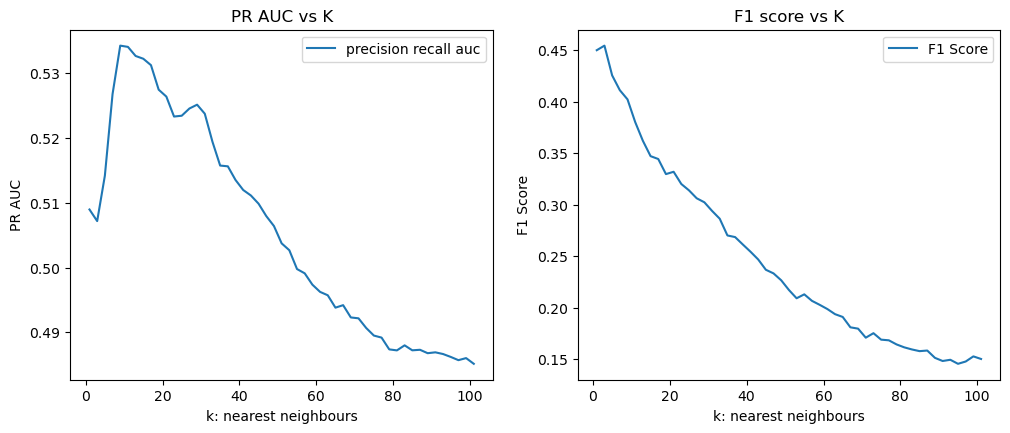

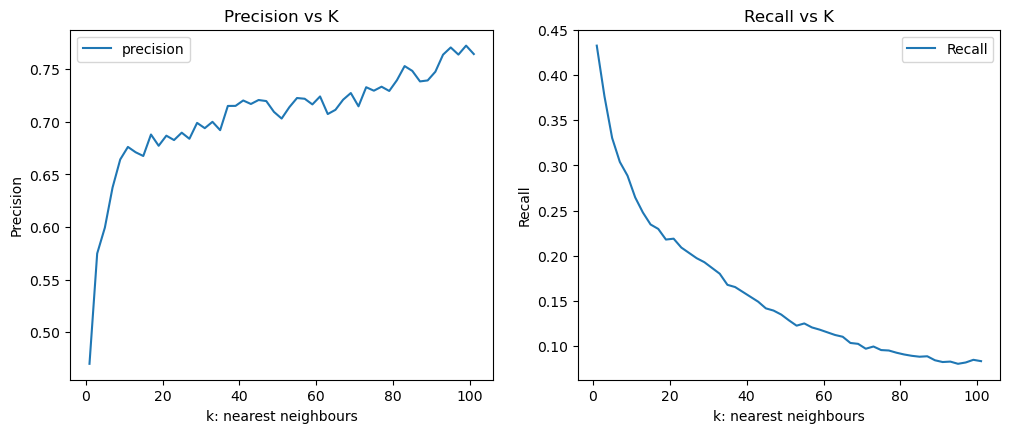

In [193]:
f = plt.figure(figsize=(12,10))
ax = f.add_subplot(2,2,1)
sns.lineplot(x=prx, y=pr_auc, palette="pastel", label='precision recall auc')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('PR AUC')
ax.set_title('PR AUC vs K')

ax = f.add_subplot(2,2,2)
sns.lineplot(x=fsx, y=fsy, palette="pastel", label='F1 Score')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('F1 Score')
ax.set_title('F1 score vs K')

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(2,2,1)
sns.lineplot(x=precx, y=precy, palette="pastel", label='precision')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('Precision')
ax.set_title('Precision vs K')

ax = f.add_subplot(2,2,2)
sns.lineplot(x=recx, y=recy, palette="pastel", label='Recall')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('Recall')
ax.set_title('Recall vs K')

In [194]:
print('For K', prx[np.argmax(pr_auc)], 'PR auc is maximum', max(pr_auc))

For K 9 PR auc is maximum 0.5342417442773276


precision 0.78 recall 0.37


Text(0.5, 1.0, 'Confusion matrix')

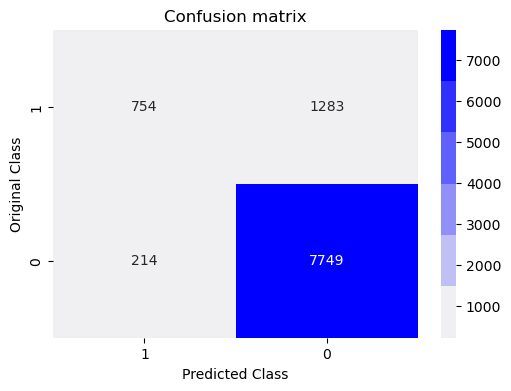

In [195]:
#Final numbers for K = 9
knn = KNN(9, 'cityblock')
x_scale = ds.fit_transform(x)
knn.fit(x_scale,y)
ypred = knn.predict(x_scale)
knn.get_performance_metrics(y,ypred)
print('precision', np.round(knn.precision,2), 'recall', np.round(knn.recall,2))
C=knn.cfm
B = C/C.sum(axis = 0) 
A = (C.T/C.sum(axis = 1)).T 
plt.figure(figsize=(20,4)) 

labels = [1,2] 

cmap=sns.light_palette("blue") 
plt.subplot(1, 3, 1) 
sns.heatmap(C, cmap=cmap, annot = True, xticklabels = [1, 0], yticklabels = [1,0], fmt = 'd')  
plt.xlabel('Predicted Class') 
plt.ylabel('Original Class') 
plt.title("Confusion matrix") 

#### Business logic


In [ ]:
#Business Logic may suggest to have higher Recall even at the expense of lower precision Hence lets try k =5,7

precision 0.79 recall 0.42


Text(0.5, 1.0, 'Confusion matrix')

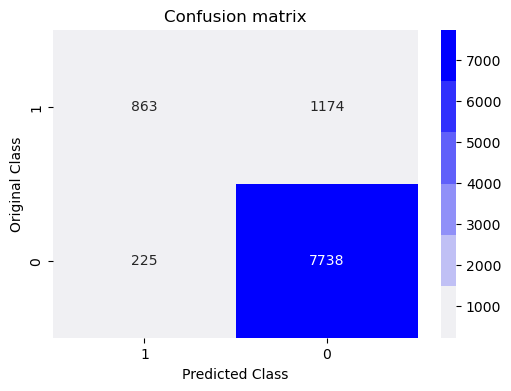

In [406]:
#Final numbers for K = 7
knn = KNN(7, 'cityblock')
x_scale = ds.fit_transform(x)
knn.fit(x_scale,y)
ypred = knn.predict(x_scale)
knn.get_performance_metrics(y,ypred)
print('precision', np.round(knn.precision,2), 'recall', np.round(knn.recall,2))
C=knn.cfm
B = C/C.sum(axis = 0) 
A = (C.T/C.sum(axis = 1)).T 
plt.figure(figsize=(20,4)) 

labels = [1,2] 

cmap=sns.light_palette("blue") 
plt.subplot(1, 3, 1) 
sns.heatmap(C, cmap=cmap, annot = True, xticklabels = [1, 0], yticklabels = [1,0], fmt = 'd')  
plt.xlabel('Predicted Class') 
plt.ylabel('Original Class') 
plt.title("Confusion matrix") 

precision 0.81 recall 0.49


Text(0.5, 1.0, 'Confusion matrix')

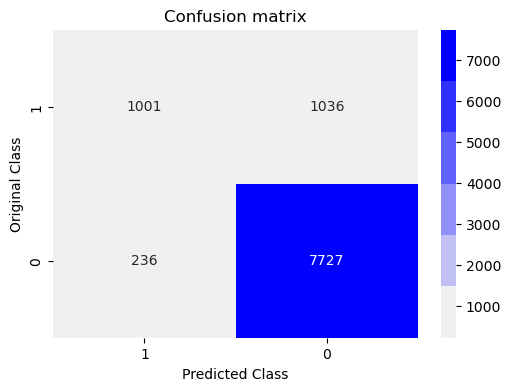

In [408]:
#Final numbers for K = 5
knn = KNN(5, 'cityblock')
x_scale = ds.fit_transform(x)
knn.fit(x_scale,y)
ypred = knn.predict(x_scale)
knn.get_performance_metrics(y,ypred)
print('precision', np.round(knn.precision,2), 'recall', np.round(knn.recall,2))
C=knn.cfm
B = C/C.sum(axis = 0) 
A = (C.T/C.sum(axis = 1)).T 
plt.figure(figsize=(20,4)) 

labels = [1,2] 

cmap=sns.light_palette("blue") 
plt.subplot(1, 3, 1) 
sns.heatmap(C, cmap=cmap, annot = True, xticklabels = [1, 0], yticklabels = [1,0], fmt = 'd')  
plt.xlabel('Predicted Class') 
plt.ylabel('Original Class') 
plt.title("Confusion matrix")

#### Weighted KNN  

In [209]:
#Since data is skewed we need to make sure that the distribution remains similar to original data in each split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state =43)
ds = data_scaling()
pr_overall = {}
fscore = {}
prec_score = {}
recall_score = {}

for k in tqdm(range(1,102,2)):
    split_num = 1
    knn = KNN(k, 'cityblock')
    pr_overall[k] = []
    fscore[k] = []
    prec_score[k] = []
    recall_score[k] = []
    for train_index, test_index in skf.split(x,y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        x_scaled_train = ds.fit_transform(x_train)
        x_scaled_test = ds.transform(x_test)
        knn.fit(x_scaled_train,y_train)
        
        ypred = knn.predict(x_scaled_test, weight_dist=True)
        ypred_prob = knn.predict_proba(x_scaled_test, weight_dist=True)
        knn.get_performance_metrics(y_test, ypred)
        
        precision, recall, thresholds = metrics.precision_recall_curve(y_test, ypred_prob)
        pr_score = metrics.auc(recall, precision)
        #print('num_neigh', k, 'auc for split', split_num, 'is', auc_score, 'cfm is', knn.cfm)
        split_num+=1
        pr_overall[k].append(pr_score)
        fscore[k].append(knn.F1_score)
        prec_score[k].append(knn.precision)
        recall_score[k].append(knn.recall)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [30:55<00:00, 36.39s/it]


In [210]:
prx, pr_auc = [], []
for key, value in pr_overall.items():
    prx.append(key)
    pr_auc.append(np.mean(value))
    
fsx, fsy = [], []
for key, value in fscore.items():
    fsx.append(key)
    fsy.append(np.mean(value))

precx, precy = [], []
for key, value in prec_score.items():
    precx.append(key)
    precy.append(np.mean(value))
    
recx, recy = [], []
for key, value in recall_score.items():
    recx.append(key)
    recy.append(np.mean(value))


Text(0.5, 1.0, 'Recall vs K')

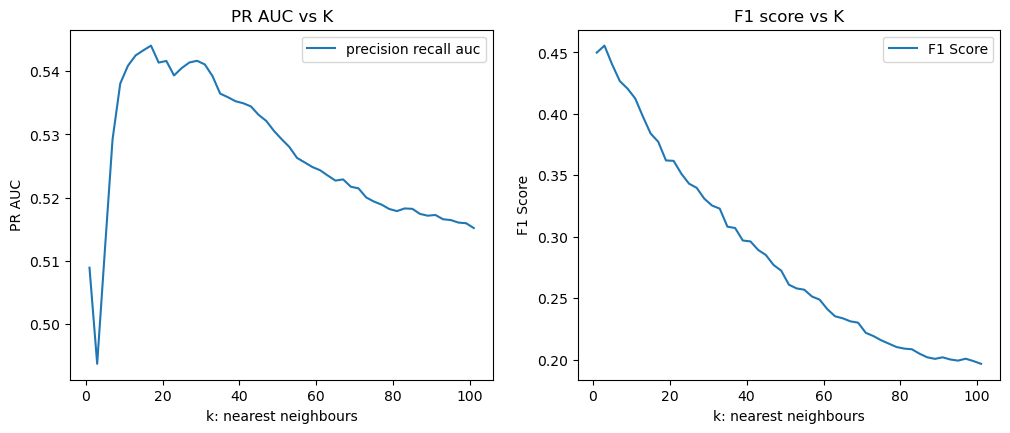

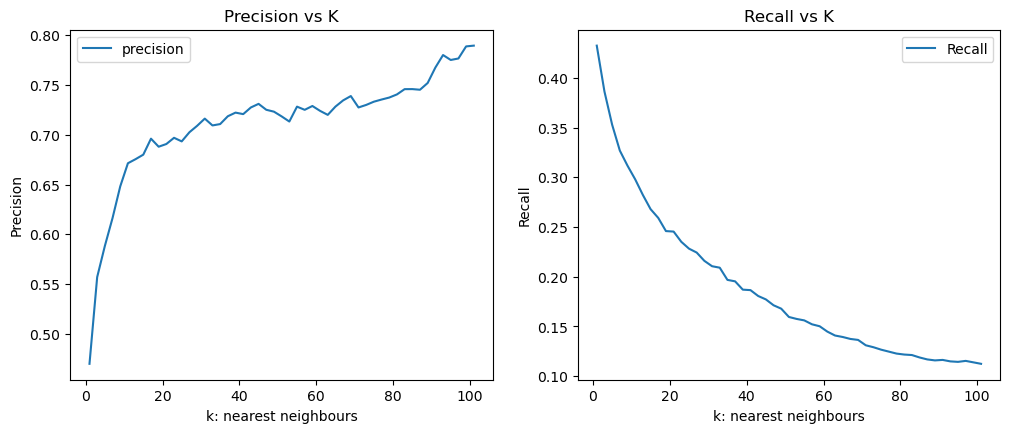

In [211]:
f = plt.figure(figsize=(12,10))
ax = f.add_subplot(2,2,1)
sns.lineplot(x=prx, y=pr_auc, palette="pastel", label='precision recall auc')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('PR AUC')
ax.set_title('PR AUC vs K')

ax = f.add_subplot(2,2,2)
sns.lineplot(x=fsx, y=fsy, palette="pastel", label='F1 Score')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('F1 Score')
ax.set_title('F1 score vs K')

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(2,2,1)
sns.lineplot(x=precx, y=precy, palette="pastel", label='precision')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('Precision')
ax.set_title('Precision vs K')

ax = f.add_subplot(2,2,2)
sns.lineplot(x=recx, y=recy, palette="pastel", label='Recall')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('Recall')
ax.set_title('Recall vs K')

In [212]:
print('For K', prx[np.argmax(pr_auc)], 'PR auc is maximum', max(pr_auc))

For K 17 PR auc is maximum 0.5440222335448807


#### Balancing the data 

In [34]:
df2_pos = df2[df2['Exited']==1]
df2_neg = df2[df2['Exited']==0]
y_pos = df2_pos['Exited'].values
x_pos = df2_pos.drop(columns=['Exited']).values

y_neg = df2_neg['Exited'].values
x_neg = df2_neg.drop(columns=['Exited']).values
x_neg.shape

(7963, 11)

In [36]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_neg, y_neg, test_size=0.28, random_state=42)

In [43]:
xstacked = np.vstack((xtest, x_pos))
ystacked = np.hstack((ytest, y_pos))

In [45]:
ystacked.shape

(4267,)

In [46]:
#Since data is skewed we need to make sure that the distribution remains similar to original data in each split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state =43)
ds = data_scaling()
pr_overall = {}
fscore = {}
prec_score = {}
recall_score = {}

for k in tqdm(range(1,102,2)):
    split_num = 1
    knn = KNN(k, 'cityblock')
    pr_overall[k] = []
    fscore[k] = []
    prec_score[k] = []
    recall_score[k] = []
    for train_index, test_index in skf.split(xstacked,ystacked):
        x_train, x_test = xstacked[train_index], xstacked[test_index]
        y_train, y_test = ystacked[train_index], ystacked[test_index]
        x_scaled_train = ds.fit_transform(x_train)
        x_scaled_test = ds.transform(x_test)
        knn.fit(x_scaled_train,y_train)
        
        ypred = knn.predict(x_scaled_test)
        ypred_prob = knn.predict_proba(x_scaled_test)
        knn.get_performance_metrics(y_test, ypred)
        
        precision, recall, thresholds = metrics.precision_recall_curve(y_test, ypred_prob)
        pr_score = metrics.auc(recall, precision)
        split_num+=1
        pr_overall[k].append(pr_score)
        fscore[k].append(knn.F1_score)
        prec_score[k].append(knn.precision)
        recall_score[k].append(knn.recall)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [01:41<00:00,  2.00s/it]


In [47]:
prx, pr_auc = [], []
for key, value in pr_overall.items():
    prx.append(key)
    pr_auc.append(np.mean(value))
    
fsx, fsy = [], []
for key, value in fscore.items():
    fsx.append(key)
    fsy.append(np.mean(value))

precx, precy = [], []
for key, value in prec_score.items():
    precx.append(key)
    precy.append(np.mean(value))
    
recx, recy = [], []
for key, value in recall_score.items():
    recx.append(key)
    recy.append(np.mean(value))

Text(0.5, 1.0, 'Recall vs K')

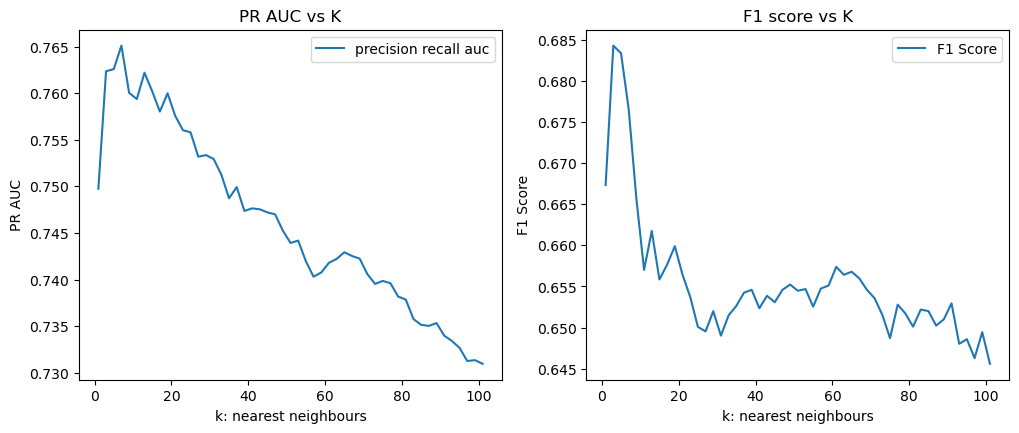

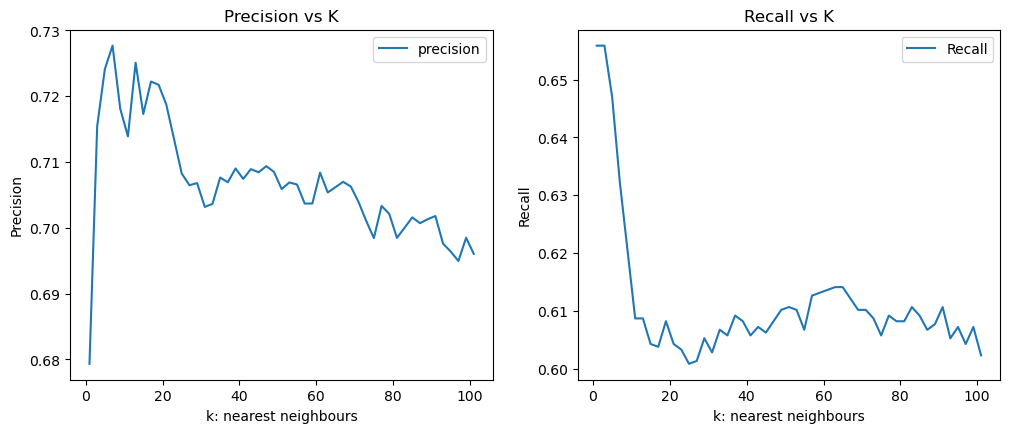

In [48]:
f = plt.figure(figsize=(12,10))
ax = f.add_subplot(2,2,1)
sns.lineplot(x=prx, y=pr_auc, palette="pastel", label='precision recall auc')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('PR AUC')
ax.set_title('PR AUC vs K')

ax = f.add_subplot(2,2,2)
sns.lineplot(x=fsx, y=fsy, palette="pastel", label='F1 Score')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('F1 Score')
ax.set_title('F1 score vs K')

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(2,2,1)
sns.lineplot(x=precx, y=precy, palette="pastel", label='precision')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('Precision')
ax.set_title('Precision vs K')

ax = f.add_subplot(2,2,2)
sns.lineplot(x=recx, y=recy, palette="pastel", label='Recall')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('Recall')
ax.set_title('Recall vs K')

In [49]:
print('For K', prx[np.argmax(pr_auc)], 'PR auc is maximum', max(pr_auc))

For K 7 PR auc is maximum 0.7651125352059591


precision 0.81 recall 0.73


Text(0.5, 1.0, 'Confusion matrix')

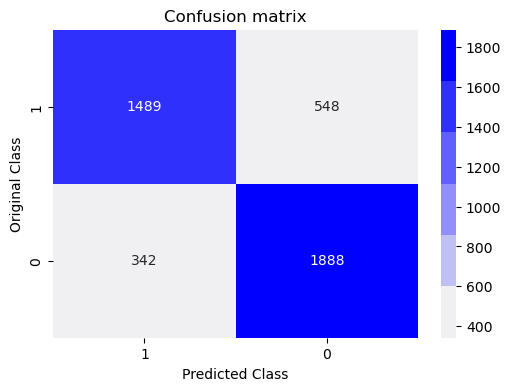

In [51]:
#Final numbers for K = 7
knn = KNN(7, 'cityblock')
x_scale = ds.fit_transform(xstacked)
knn.fit(x_scale,ystacked)
ypred = knn.predict(x_scale)
knn.get_performance_metrics(ystacked,ypred)
print('precision', np.round(knn.precision,2), 'recall', np.round(knn.recall,2))
C=knn.cfm
B = C/C.sum(axis = 0) 
A = (C.T/C.sum(axis = 1)).T 
plt.figure(figsize=(20,4)) 

labels = [1,2] 

cmap=sns.light_palette("blue") 
plt.subplot(1, 3, 1) 
sns.heatmap(C, cmap=cmap, annot = True, xticklabels = [1, 0], yticklabels = [1,0], fmt = 'd')  
plt.xlabel('Predicted Class') 
plt.ylabel('Original Class') 
plt.title("Confusion matrix")

#### Removing Outlier 

In [97]:
#lets clip the extreme values in Estimated Salary to 10th percentile and 90th percentile
sal = df[df['EstimatedSalary'].notnull()]['EstimatedSalary'].sort_values().values
sal_min = sal[int(len(sal)/10)]
sal_max = sal[int((len(sal)/10)*9)]
#sns.boxplot(y='EstimatedSalary', data = df[(df['EstimatedSalary']>mu-3*std)& (df['EstimatedSalary']<mu+3*std)])

In [98]:
bal = df['Balance'].sort_values().values
bal_min = bal[int(len(bal)/10)]
bal_max = bal[int((len(bal)/10)*9)]

In [99]:
sal_min, sal_max, bal_min, bal_max

(20066.38, 179718.17, 0.0, 149297.19)

In [100]:
df['EstSal_outlier_removed'] = df['EstimatedSalary'].fillna(value=df['EstimatedSalary'].median())

df['Balance'] = df['Balance'].apply(lambda x:float(x))
df['EstimatedSalary'] = df['EstimatedSalary'].apply(lambda x:float(x))
df['EstSal_outlier_removed'] = df['EstSal_outlier_removed'].apply(lambda x:sal_min if x<sal_min else x)
df['EstSal_outlier_removed'] = df['EstSal_outlier_removed'].apply(lambda x:sal_max if x>sal_max else x)

df['Balance_outlier_removed'] = df['Balance'].apply(lambda x:bal_max if x>bal_max else x)
df['Balance_outlier_removed'] = df['Balance_outlier_removed'].apply(lambda x:bal_min if x<bal_min else x)

In [101]:
df['Balance_outlier_removed'] = df['Balance'].apply(lambda x:bal_max if x>bal_max else x)
df['Balance_outlier_removed'] = df['Balance_outlier_removed'].apply(lambda x:bal_min if x<bal_min else x)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,EstSalary_median,log_est_salary,EstSal_outlier_removed,Balance_outlier_removed
0,619,France,missing,42,2,0.00,1,1,1,10134888.0,1,10134888.0,16.131494,179718.17,0.00
1,608,Spain,Female,41,1,83807.86,1,0,1,11254258.0,0,11254258.0,16.236257,179718.17,83807.86
2,502,France,Female,42,8,159660.80,3,1,0,11393157.0,1,11393157.0,16.248524,179718.17,149297.19
3,699,France,Female,39,1,0.00,2,0,0,0.0,0,0.0,0.000000,20066.38,0.00
4,850,Spain,Female,43,2,125510.82,1,1,1,7908410.0,0,7908410.0,15.883437,179718.17,125510.82


Text(0.5, 1.0, 'Distribution of est_salary w/o outliers with Exited')

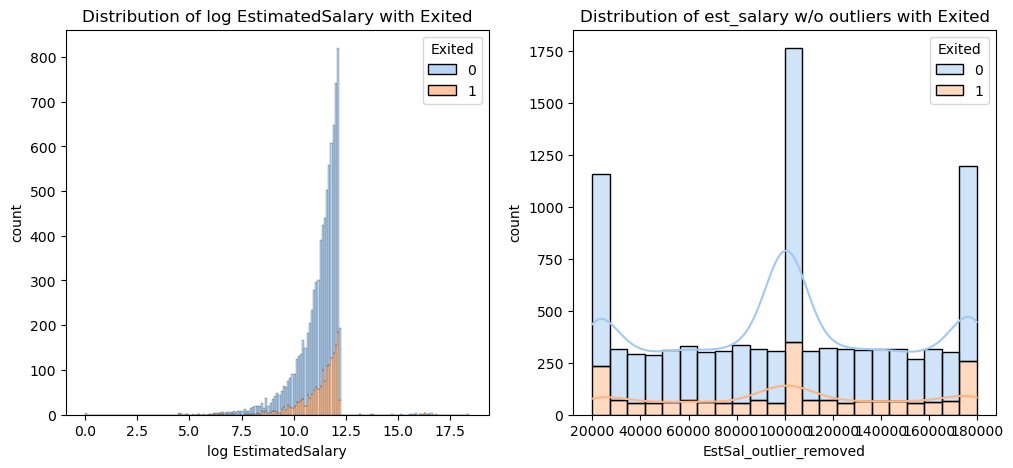

In [102]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,2,1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="log_est_salary", kde=False,
             palette="pastel", hue="Exited",
             element="bars", legend=True)
ax.set_xlabel('log EstimatedSalary')
ax.set_ylabel('count')
ax.set_title('Distribution of log EstimatedSalary with Exited')

#df['est_salary_out_rem'] = df['EstSal_outlier_removed']
ax = f.add_subplot(1,2,2)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="EstSal_outlier_removed", kde=True, palette="pastel", hue="Exited", element="bars", legend=True)
ax.set_xlabel('EstSal_outlier_removed')
ax.set_ylabel('count')
ax.set_title('Distribution of est_salary w/o outliers with Exited')

Text(0.5, 1.0, 'Boxplot of EstimatedSalary')

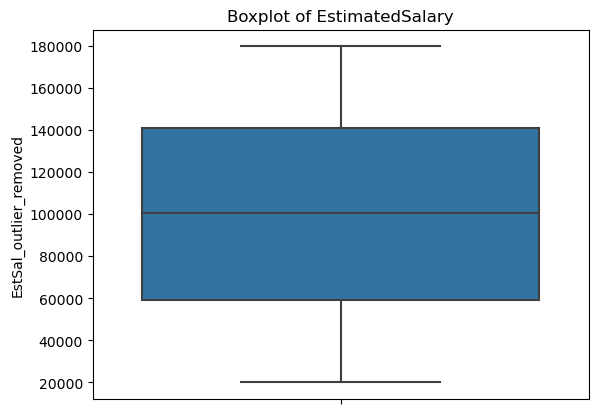

In [103]:
sns.boxplot(y='EstSal_outlier_removed', data = df)
plt.title('Boxplot of EstimatedSalary')

In [70]:
#converting categorical data gender and country to one hot encoding
ohe_gender = pd.get_dummies(df['Gender'])
ohe_geog = pd.get_dummies(df['Geography'])
df3 =pd.concat([df,ohe_gender, ohe_geog], axis='columns')
df3=df3.drop(columns=['Geography', 'Gender', 'missing', 'Spain','log_est_salary', 'EstimatedSalary', 'EstSalary_median', 'Balance', 'log_est_salary_out_rem', 'est_salary_out_rem'])
df3.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,EstSal_outlier_removed,Balance_outlier_removed,Female,Male,France,Germany
0,619,42,2,1,1,1,1,179718.17,0.00,0,0,1,0
1,608,41,1,1,0,1,0,179718.17,83807.86,1,0,0,0
2,502,42,8,3,1,0,1,179718.17,149297.19,1,0,1,0
3,699,39,1,2,0,0,0,20066.38,0.00,1,0,1,0
4,850,43,2,1,1,1,0,179718.17,125510.82,1,0,0,0


In [71]:
y=df3['Exited'].values
df4=df3.drop(columns='Exited')
x=df4.values
print(x.shape, y.shape)
df4.head()

(10000, 12) (10000,)


,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstSal_outlier_removed,Balance_outlier_removed,Female,Male,France,Germany
0,619,42,2,1,1,1,179718.17,0.00,0,0,1,0
1,608,41,1,1,0,1,179718.17,83807.86,1,0,0,0
2,502,42,8,3,1,0,179718.17,149297.19,1,0,1,0
3,699,39,1,2,0,0,20066.38,0.00,1,0,1,0
4,850,43,2,1,1,1,179718.17,125510.82,1,0,0,0


In [417]:
#Since data is skewed we need to make sure that the distribution remains similar to original data in each split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state =43)
ds = data_scaling()
pr_overall2 = {}
fscore2 = {}
prec_score2 = {}
recall_score2 = {}
for k in range(1,101,2):
    split_num = 1
    knn = KNN(k, 'cityblock')
    pr_overall2[k] = []
    fscore2[k] = []
    prec_score2[k] = []
    recall_score2[k] = []
    for train_index, test_index in skf.split(x,y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        x_scaled_train = ds.fit_transform(x_train)
        x_scaled_test = ds.transform(x_test)
        knn.fit(x_scaled_train,y_train)
        ypred = knn.predict(x_scaled_test)
        ypred_prob = knn.predict_proba(x_scaled_test)
        
        knn.get_performance_metrics(y_test, ypred)
        precision, recall, thresholds = metrics.precision_recall_curve(y_test, ypred_prob)
        pr_score = metrics.auc(recall, precision)
        
        #print('num_neigh', k, 'auc for split', split_num, 'is', auc_score, 'cfm is', knn.cfm)
        split_num+=1
        pr_overall2[k].append(pr_score)
        fscore2[k].append(knn.F1_score)
        prec_score2[k].append(knn.precision)
        recall_score2[k].append(knn.recall)

In [418]:
prx2, pr_auc2 = [], []
for key, value in pr_overall2.items():
    prx2.append(key)
    pr_auc2.append(np.mean(value))
    
fsx2, fsy2 = [], []
for key, value in fscore2.items():
    fsx2.append(key)
    fsy2.append(np.mean(value))

precx2, precy2 = [], []
for key, value in prec_score2.items():
    precx2.append(key)
    precy2.append(np.mean(value))
    
recx2, recy2 = [], []
for key, value in recall_score2.items():
    recx2.append(key)
    recy2.append(np.mean(value))

Text(0.5, 1.0, 'Recall vs K')

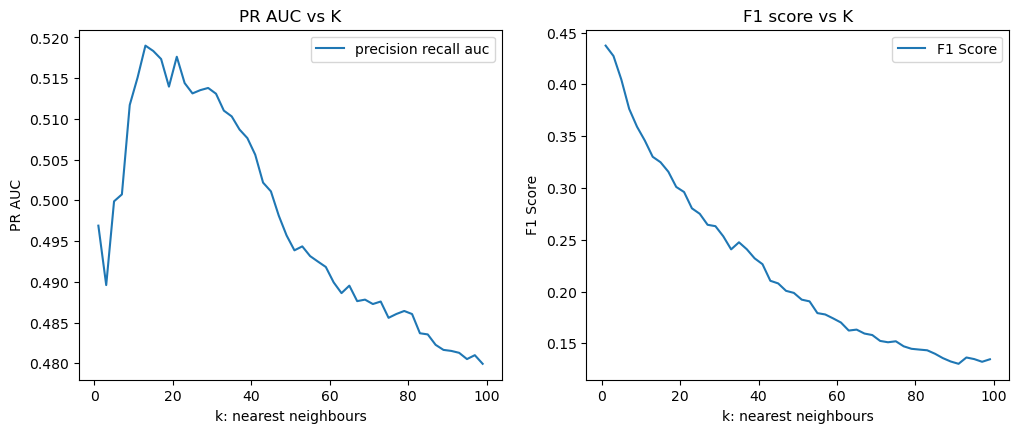

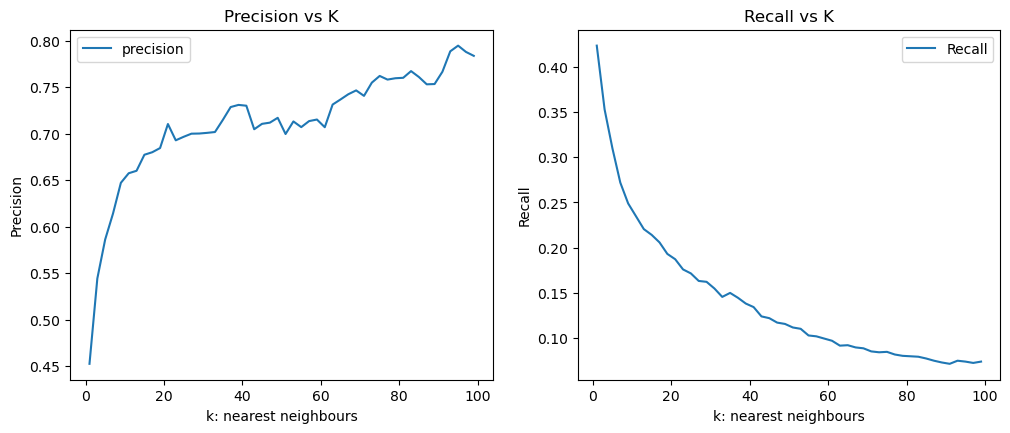

In [419]:
f = plt.figure(figsize=(12,10))
ax = f.add_subplot(2,2,1)
sns.lineplot(x=prx2, y=pr_auc2, palette="pastel", label='precision recall auc')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('PR AUC')
ax.set_title('PR AUC vs K')

ax = f.add_subplot(2,2,2)
sns.lineplot(x=fsx2, y=fsy2, palette="pastel", label='F1 Score')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('F1 Score')
ax.set_title('F1 score vs K')

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(2,2,1)
sns.lineplot(x=precx2, y=precy2, palette="pastel", label='precision')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('Precision')
ax.set_title('Precision vs K')

ax = f.add_subplot(2,2,2)
sns.lineplot(x=recx2, y=recy2, palette="pastel", label='Recall')
ax.set_xlabel('k: nearest neighbours')
ax.set_ylabel('Recall')
ax.set_title('Recall vs K')

In [420]:
print('For K', prx2[np.argmax(pr_auc2)], 'PR auc is maximum', max(pr_auc2))

For K 13 PR auc is maximum 0.518990330415585


precision 0.79 recall 0.29


Text(0.5, 1.0, 'Confusion matrix')

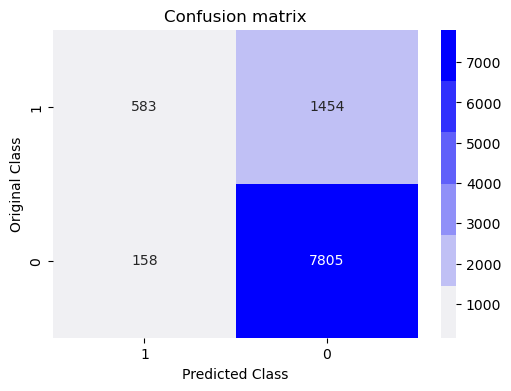

In [421]:
knn = KNN(13, 'cityblock')
x_scale = ds.fit_transform(x)
knn.fit(x_scale,y)
ypred = knn.predict(x_scale)
knn.get_performance_metrics(y,ypred)
print('precision', np.round(knn.precision,2), 'recall', np.round(knn.recall,2))
C=knn.cfm
B = C/C.sum(axis = 0) 
A = (C.T/C.sum(axis = 1)).T 
plt.figure(figsize=(20,4)) 

labels = [1,2] 

cmap=sns.light_palette("blue") 
plt.subplot(1, 3, 1) 
sns.heatmap(C, cmap=cmap, annot = True, xticklabels = [1, 0], yticklabels = [1,0], fmt = 'd')  
plt.xlabel('Predicted Class') 
plt.ylabel('Original Class') 
plt.title("Confusion matrix") 

#### Next Steps 

In [ ]:
# Feature selection by removing features that are correlated with each other
# Oversampling techniques like SMOTE
# Try different distance metrics

In [72]:
df4.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstSal_outlier_removed,Balance_outlier_removed,Female,Male,France,Germany
0,619,42,2,1,1,1,179718.17,0.00,0,0,1,0
1,608,41,1,1,0,1,179718.17,83807.86,1,0,0,0
2,502,42,8,3,1,0,179718.17,149297.19,1,0,1,0
3,699,39,1,2,0,0,20066.38,0.00,1,0,1,0
4,850,43,2,1,1,1,179718.17,125510.82,1,0,0,0


<AxesSubplot:>

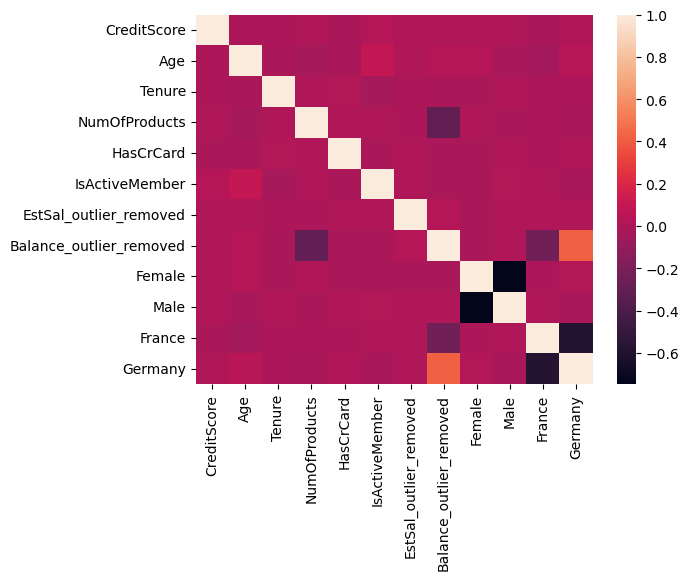

In [75]:
sns.heatmap(df4.corr())

[Text(0.5, 1.0, 'Churn data T-SNE projection')]

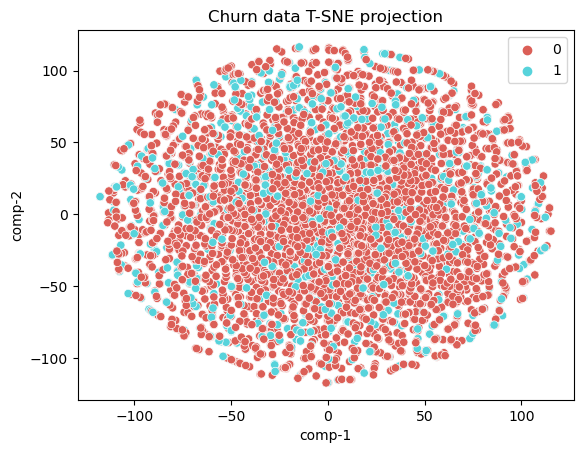

In [85]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(df2.drop(columns=['Male', 'Exited']).values)
df_v = pd.DataFrame()
df_v["y"] = y
df_v["comp-1"] = X_embedded[:,0]
df_v["comp-2"] = X_embedded[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_v.y.tolist(),palette=sns.color_palette("hls", 2), data=df_v).set(title="Churn data T-SNE projection") 